In [140]:
import geopandas as gp
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import table
import seaborn as sns



In [141]:
filepath = '/Users/ameliabaum/Desktop/Amelia/CRA_Thesis/communityreinvestmentact/results/udp_regressions/'
udp_2017 = pd.read_csv('/Users/ameliabaum/Desktop/Amelia/CRA_Thesis/communityreinvestmentact/data/reference/udp_2017results.csv')
rec1_vars_dummies = pd.read_csv('/Users/ameliabaum/Desktop/Amelia/CRA_Thesis/communityreinvestmentact/data/regression/demog_with_cra_dummies_201314.csv').drop("Total Loans", axis=1)
loans_09 = pd.read_csv('/Users/ameliabaum/Desktop/Amelia/CRA_Thesis/communityreinvestmentact/data/regression/2009_loans.csv')
loans_1314 = pd.read_csv('/Users/ameliabaum/Desktop/Amelia/CRA_Thesis/communityreinvestmentact/data/regression/201314_loans.csv')
loans_151617 = pd.read_csv('/Users/ameliabaum/Desktop/Amelia/CRA_Thesis/communityreinvestmentact/data/regression/20151617_loans.csv')


In [142]:
rec1_udp_merge = pd.merge(rec1_vars_dummies, udp_2017, how='left', right_on='geo_fips', left_on='Geoid')
all_vars_09 = pd.merge(rec1_udp_merge, loans_09, how='left', on='Geoid').rename({"Percent of population 25 years and over with Bachelor's degree": "Pct Bachelor's degree"}, axis=1,inplace=False)
all_vars_1314 = pd.merge(rec1_udp_merge, loans_1314, how='left', on='Geoid').rename({"Percent of population 25 years and over with Bachelor's degree": "Pct Bachelor's degree"}, axis=1,inplace=False)
all_vars_151617 = pd.merge(rec1_udp_merge, loans_151617, how='left', on='Geoid').rename({"Percent of population 25 years and over with Bachelor's degree": "Pct Bachelor's degree"}, axis=1,inplace=False)


In [143]:
def encode_udp(row):
    if (row == 'MHI - Advanced Gentrification'):
        return 5
    elif (row == 'MHI - Not Losing Low Income Households'):
        return 4
    elif (row == 'LI - Ongoing Gentrification and/or Displacement'):
        return 3     
    elif (row == 'LI - At Risk of Gentrification and/or Displacement'):
        return 2        
    elif (row == 'LI - Not Losing Low Income Households'):
        return 1 
    else:
        return np.nan #this includes all of the exclusion typologies, college town, or unreliable data


In [169]:
all_vars_09["UDP code"] = all_vars_09["Typology"].apply(lambda x: encode_udp(x))
all_vars_09 = all_vars_09.dropna()
x_vars_2009 = all_vars_09[['% Loans to MHI borrowers', 'CRA', "Pct Bachelor's degree", 
                "% below poverty level","% Single Family","Percent NH White alone", 
                "Total number of housing units","Median home value", 'Median income',
       'Total loans 2009']]


x_vars_2009_constant = sm.add_constant(x_vars_2009)

y_vars_2009 = all_vars_09["UDP code"]


In [145]:
print("5", sum(all_vars_09["UDP code"] == 5))
print("4", sum(all_vars_09["UDP code"] == 4))
print("3", sum(all_vars_09["UDP code"] == 3))
print("2", sum(all_vars_09["UDP code"] == 2))
print("1", sum(all_vars_09["UDP code"] == 1))


5 59
4 113
3 196
2 154
1 217


In [170]:
mn = sm.MNLogit(y_vars_2009, x_vars_2009_constant, J=4, K=20)
results_mn = mn.fit()
# print(results_mn.summary())
pvals = results_mn.pvalues.values
odds = np.exp(results_mn.params).values
P = pd.DataFrame(data=pvals, columns=["P val code 2", "P val code 3", "P val code 4", "P val code 5"], index=results_mn.pvalues.index)
O = pd.DataFrame(data=odds, columns=["odds code 2", "odds code 3", "odds code 4", "odds code 5"], index=results_mn.pvalues.index)
both = pd.concat([O,P], axis=1)
both
# both.to_csv(filepath+"results_2009_udp_multinomial.csv")
# with open(filepath+ '2009_udp_multinomial_newencoding.html', 'w') as outfile:
#     outfile.write(results_mn.summary().as_html())

Optimization terminated successfully.
         Current function value: 1.030229
         Iterations 9


,odds code 2,odds code 3,odds code 4,odds code 5,P val code 2,P val code 3,P val code 4,P val code 5
const,67.321802,0.655159,0.000006,0.000221,0.000309,0.705705,1.071600e-11,3.734890e-07
% Loans to MHI borrowers,22.757604,226.604296,35.565466,169.766328,0.009006,0.000003,8.805325e-02,7.278106e-03
CRA,1.809983,1.422314,0.130551,0.748194,0.057404,0.222747,7.889756e-03,5.308957e-01
Pct Bachelor's degree,0.003317,1.832018,0.015694,0.126452,0.013323,0.769957,2.468641e-01,5.245153e-01
% below poverty level,0.081271,319.751768,0.000548,291.220131,0.286710,0.009979,1.970561e-01,2.061800e-01
% Single Family,0.219409,0.150823,176.086353,0.027662,0.031799,0.003216,5.048918e-05,5.258307e-05
Percent NH White alone,0.024967,0.035827,5.620649,1.424297,0.000006,0.000009,7.956480e-02,7.361839e-01
Total number of housing units,0.999967,1.000084,0.999868,0.999660,0.893408,0.704195,7.400100e-01,3.230943e-01
Median home value,1.000000,1.000000,0.999997,1.000000,0.684350,0.753306,9.318408e-02,9.848389e-01
Median income,0.999957,0.999974,1.000088,1.000079,0.001396,0.034118,1.585699e-07,2.318119e-07


In [146]:
# all_vars_151617["CRA Eligible"]

In [147]:
all_vars_09["Typology"].unique()

array(['LI - Not Losing Low Income Households',
       'MHI - Advanced Gentrification',
       'LI - Ongoing Gentrification and/or Displacement',
       'LI - At Risk of Gentrification and/or Displacement',
       'MHI - Not Losing Low Income Households'], dtype=object)

In [148]:
# covariates = np.array(["Pct Bachelor's degree","% below poverty level",
#       "% Single Family", "% Owner Occupied", "Percent NH White alone", "Total number of housing units", 
#                  "Median home value","Median income"])

mh_total = np.array(["Total loans 2009", "% Loans to MHI borrowers"])

udp1 = all_vars_09[all_vars_09["Typology"] == 'LI - Not Losing Low Income Households'][[col for col in mh_total]].mean(axis=0)
udp2 = all_vars_09[all_vars_09["Typology"] == 'LI - At Risk of Gentrification and/or Displacement'][[col for col in mh_total]].mean(axis=0)
udp3 = all_vars_09[all_vars_09["Typology"] == 'LI - Ongoing Gentrification and/or Displacement'][[col for col in mh_total]].mean(axis=0)
udp4 = all_vars_09[all_vars_09["Typology"] == 'MHI - Not Losing Low Income Households'][[col for col in mh_total]].mean(axis=0)
udp5 = all_vars_09[all_vars_09["Typology"] == 'MHI - Advanced Gentrification'][[col for col in mh_total]].mean(axis=0)

elig = all_vars_09[all_vars_09["CRA Eligible"] == 'eligible'][[col for col in mh_total]].mean(axis=0)
not_elig = all_vars_09[all_vars_09["CRA Eligible"] == 'not eligible'][[col for col in mh_total]].mean(axis=0)




/Users/ameliabaum/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


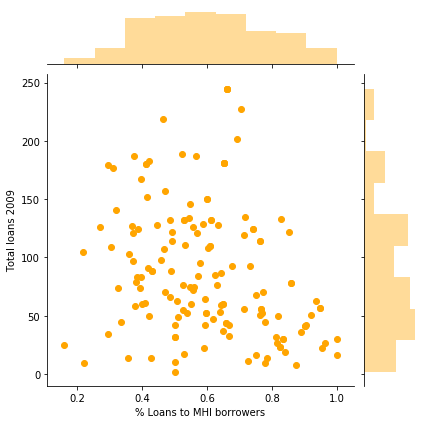

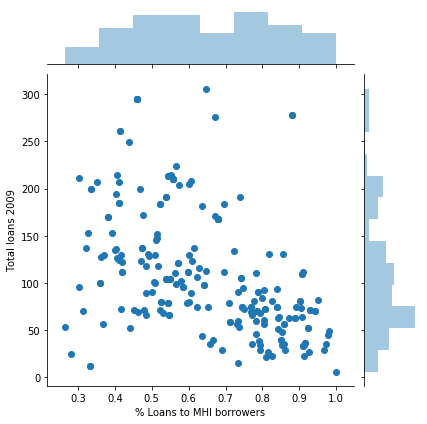

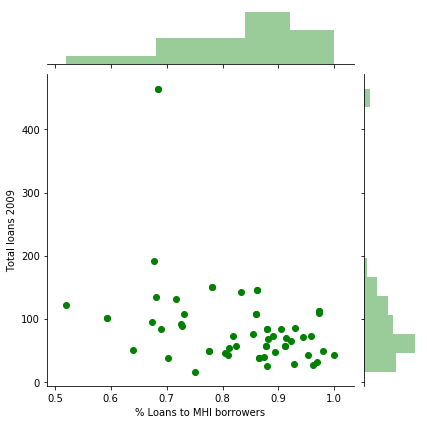

In [149]:
sns.jointplot(data=all_vars_09[all_vars_09["Typology"]=='LI - At Risk of Gentrification and/or Displacement'], x="% Loans to MHI borrowers", y="Total loans 2009", color='orange')
sns.jointplot(data=all_vars_09[all_vars_09["Typology"]=='LI - Not Losing Low Income Households'], x="% Loans to MHI borrowers", y="Total loans 2009")
sns.jointplot(data=all_vars_09[all_vars_09["Typology"]=='MHI - Advanced Gentrification'], x="% Loans to MHI borrowers", y="Total loans 2009", color='green')
  
                               
                               

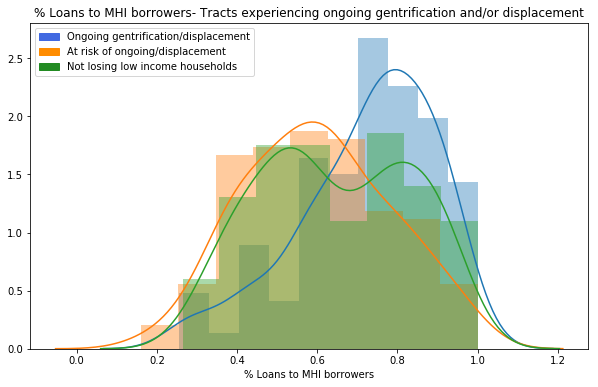

In [150]:
import matplotlib.patches as mpatches
plt.figure(figsize = (10,6))
plt.title("% Loans to MHI borrowers by tract categorization 2009")
sns.distplot((all_vars_09[all_vars_09["Typology"] == 'LI - Ongoing Gentrification and/or Displacement'])["% Loans to MHI borrowers"], kde=True);

# plt.title("% Loans to MHI borrowers- Tracts at risk of gentrification and/or displacement")
sns.distplot((all_vars_09[all_vars_09["Typology"] == 'LI - At Risk of Gentrification and/or Displacement'])["% Loans to MHI borrowers"], kde=True);

plt.title("% Loans to MHI borrowers- Tracts experiencing ongoing gentrification and/or displacement")
sns.distplot((all_vars_09[all_vars_09["Typology"] == 'LI - Not Losing Low Income Households'])["% Loans to MHI borrowers"], kde=True);

ongoingpatch = mpatches.Patch(color='royalblue', label='Ongoing gentrification/displacement')
riskpatch = mpatches.Patch(color='darkorange', label='At risk of ongoing/displacement')
notlosingpatch = mpatches.Patch(color='forestgreen', label='Not losing low income households')
plt.legend(handles=[ongoingpatch, riskpatch, notlosingpatch]);


plt.savefig("/Users/ameliabaum/Desktop/Amelia/CRA_Thesis/communityreinvestmentact/results/plots/pctmhi_hist_2009")



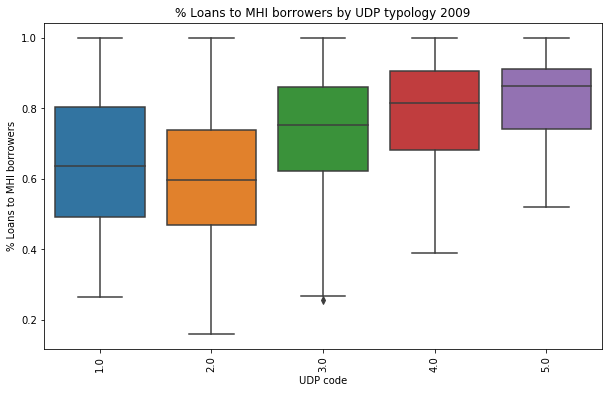

<Figure size 432x288 with 0 Axes>

In [151]:
plt.figure(figsize=(10,6))
plt.title("% Loans to MHI borrowers by UDP typology 2009")
sns.boxplot("UDP code", "% Loans to MHI borrowers", data=all_vars_09)
plt.xticks(rotation=90)
plt.show()
plt.savefig("/Users/ameliabaum/Desktop/Amelia/CRA_Thesis/communityreinvestmentact/results/plots/boxplots_bytypology_2009")


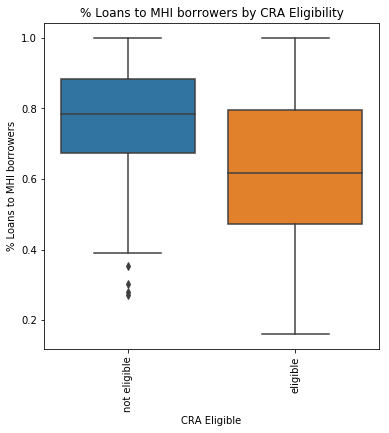

In [152]:
plt.figure(figsize=(6,6))
plt.title("% Loans to MHI borrowers by CRA Eligibility")
sns.boxplot("CRA Eligible", "% Loans to MHI borrowers", data=all_vars_09)
plt.xticks(rotation=90)
plt.show()


In [153]:
# covariates = np.array(["Pct Bachelor's degree","% below poverty level",
#       "% Single Family", "% Owner Occupied", "Percent NH White alone", "Total number of housing units", 
#                  "Median home value","Median income"])

mh_total = np.array(["Total loans 2013-2014", "% Loans to MHI borrowers"])
all_vars_1314["UDP code"] = all_vars_1314["Typology"].apply(lambda x: encode_udp(x))

udp1 = all_vars_1314[all_vars_1314["Typology"] == 'LI - Not Losing Low Income Households'][[col for col in mh_total]].mean(axis=0)
udp2 = all_vars_1314[all_vars_1314["Typology"] == 'LI - At Risk of Gentrification and/or Displacement'][[col for col in mh_total]].mean(axis=0)
udp3 = all_vars_1314[all_vars_1314["Typology"] == 'LI - Ongoing Gentrification and/or Displacement'][[col for col in mh_total]].mean(axis=0)
udp4 = all_vars_1314[all_vars_1314["Typology"] == 'MHI - Not Losing Low Income Households'][[col for col in mh_total]].mean(axis=0)
udp5 = all_vars_1314[all_vars_1314["Typology"] == 'MHI - Advanced Gentrification'][[col for col in mh_total]].mean(axis=0)

elig = all_vars_1314[all_vars_1314["CRA Eligible"] == 'eligible'][[col for col in mh_total]].mean(axis=0)
not_elig = all_vars_1314[all_vars_1314["CRA Eligible"] == 'not eligible'][[col for col in mh_total]].mean(axis=0)


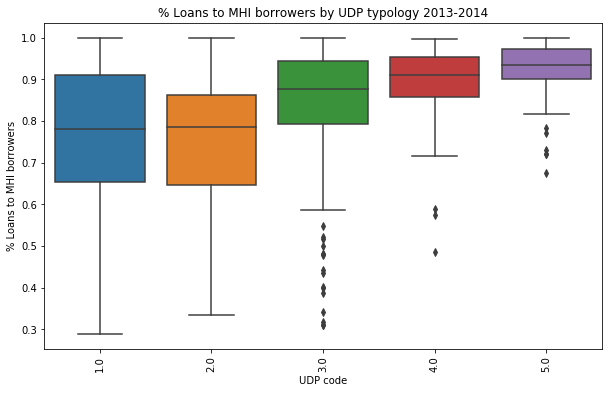

In [154]:
plt.figure(figsize=(10,6))
plt.title("% Loans to MHI borrowers by UDP typology 2013-2014")
sns.boxplot("UDP code", "% Loans to MHI borrowers", data=all_vars_1314)
plt.xticks(rotation=90)
plt.savefig("/Users/ameliabaum/Desktop/Amelia/CRA_Thesis/communityreinvestmentact/results/plots/boxplots_bytypology_201314")


In [155]:
# covariates = np.array(["Pct Bachelor's degree","% below poverty level",
#       "% Single Family", "% Owner Occupied", "Percent NH White alone", "Total number of housing units", 
#                  "Median home value","Median income"])

mh_total = np.array(["Total loans 2015-2017", "% Loans to MHI borrowers"])
all_vars_151617["UDP code"] = all_vars_151617["Typology"].apply(lambda x: encode_udp(x))

udp1 = all_vars_151617[all_vars_151617["Typology"] == 'LI - Not Losing Low Income Households'][[col for col in mh_total]].mean(axis=0)
udp2 = all_vars_151617[all_vars_151617["Typology"] == 'LI - At Risk of Gentrification and/or Displacement'][[col for col in mh_total]].mean(axis=0)
udp3 = all_vars_151617[all_vars_151617["Typology"] == 'LI - Ongoing Gentrification and/or Displacement'][[col for col in mh_total]].mean(axis=0)
udp4 = all_vars_151617[all_vars_151617["Typology"] == 'MHI - Not Losing Low Income Households'][[col for col in mh_total]].mean(axis=0)
udp5 = all_vars_151617[all_vars_151617["Typology"] == 'MHI - Advanced Gentrification'][[col for col in mh_total]].mean(axis=0)
elig = all_vars_151617[all_vars_151617["CRA Eligible"] == 'eligible'][[col for col in mh_total]].mean(axis=0)
not_elig = all_vars_151617[all_vars_151617["CRA Eligible"] == 'not eligible'][[col for col in mh_total]].mean(axis=0)

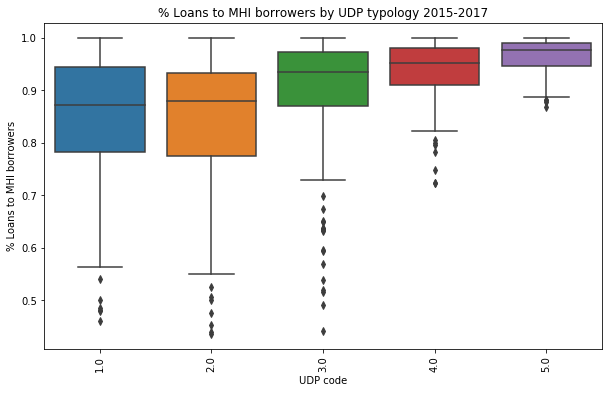

In [156]:
plt.figure(figsize=(10,6))
plt.title("% Loans to MHI borrowers by UDP typology 2015-2017")
sns.boxplot("UDP code", "% Loans to MHI borrowers", data=all_vars_151617)
plt.xticks(rotation=90)
plt.savefig("/Users/ameliabaum/Desktop/Amelia/CRA_Thesis/communityreinvestmentact/results/plots/boxplots_bytypology_201517")


In [157]:
covariates = np.array(["Percent of population 25 years and over with Bachelor's degree","% below poverty level",
      "% Single Family", "% Owner Occupied", "Percent NH White alone", "Total number of housing units", 
                 "Median home value","Median income", "Total Loans"])




In [159]:
all_vars_1314["UDP code"] = all_vars_1314["Typology"].apply(lambda x: encode_udp(x))
all_vars_1314 = all_vars_1314.dropna()
#do not include napa county
x_vars_1314 = all_vars_1314[['% Loans to MHI borrowers', 'CRA', "Pct Bachelor's degree", 
                "% below poverty level","% Single Family","Percent NH White alone", 
                "Total number of housing units",  "Median home value", 'Median income',
       'Total loans 2013-2014']]
x_vars_1314_constant = sm.add_constant(x_vars_1314)

y_vars_1314 = all_vars_1314["UDP code"]
x_vars_1314_constant.head()


,const,% Loans to MHI borrowers,CRA,Pct Bachelor's degree,% below poverty level,% Single Family,Percent NH White alone,Total number of housing units,Median home value,Median income,Total loans 2013-2014
1,1.0,1.000000,0,0.321,0.069,0.478758,0.714142,2801,718100.0,66638.0,123
2,1.0,0.980769,0,0.440,0.040,0.555446,0.698082,2020,790500.0,80391.0,104
3,1.0,0.922222,1,0.281,0.060,0.444380,0.419526,1735,572000.0,50658.0,90
4,1.0,0.871429,1,0.519,0.264,0.632653,0.338305,784,586700.0,39802.0,70
5,1.0,0.912621,1,0.194,0.081,0.572421,0.356832,2016,511600.0,32471.0,206


In [163]:
mn = sm.MNLogit(y_vars_1314, x_vars_1314_constant, J=4, K=20)
results_mn1314 = mn.fit()
pvals = results_mn1314.pvalues.values

odds = np.exp(results_mn1314.params).values
P = pd.DataFrame(data=pvals, columns=["P val code 2", "P val code 3", "P val code 4", "P val code 5"], index=results_mn1314.pvalues.index)
O = pd.DataFrame(data=odds, columns=["odds code 2", "odds code 3", "odds code 4", "odds code 5"], index=results_mn1314.pvalues.index)
both = pd.concat([O,P], axis=1)
both
# print(results_mn1314.summary())
# with open(filepath+ '201314_udp_multinomial_newgeos.html', 'w') as outfile:
#     outfile.write(results_mn1314.summary().as_html())

Optimization terminated successfully.
         Current function value: 1.037096
         Iterations 9


,odds code 2,odds code 3,odds code 4,odds code 5,P val code 2,P val code 3,P val code 4,P val code 5
const,23.062007,0.229816,0.000005,0.000029,0.010248,0.217657,1.733883e-09,5.132151e-06
% Loans to MHI borrowers,37.188860,224.155854,21.240617,761.604578,0.004295,0.000018,1.982970e-01,1.448957e-02
CRA,1.774279,1.341576,0.106045,0.723058,0.063595,0.303926,4.506023e-03,4.823494e-01
Pct Bachelor's degree,0.008241,3.856974,0.034438,0.149090,0.034749,0.507874,3.449706e-01,5.598299e-01
% below poverty level,0.106137,310.844867,0.001129,378.846472,0.338198,0.010294,2.340355e-01,1.812614e-01
% Single Family,0.186462,0.147127,282.261990,0.041500,0.016098,0.002847,9.212432e-06,4.107692e-04
Percent NH White alone,0.048057,0.085961,5.330057,2.095121,0.000055,0.000413,5.469107e-02,4.604435e-01
Total number of housing units,0.999858,1.000229,0.999931,0.999970,0.548318,0.313703,8.598410e-01,9.330304e-01
Median home value,1.000000,0.999999,0.999997,0.999999,0.911502,0.599321,9.726121e-02,5.544015e-01
Median income,0.999949,0.999975,1.000083,1.000081,0.000291,0.045105,1.463555e-06,3.214906e-07


In [164]:
all_vars_151617["UDP code"] = all_vars_151617["Typology"].apply(lambda x: encode_udp(x))
all_vars_151617 = all_vars_151617.dropna()
#do not include napa county
x_vars_151617 = all_vars_151617[['% Loans to MHI borrowers', 'CRA', "Pct Bachelor's degree", 
                "% below poverty level","% Single Family","Percent NH White alone", 
                "Total number of housing units",  "Median home value", 'Median income',
       'Total loans 2015-2017']]
x_vars_151617_constant = sm.add_constant(x_vars_151617)
y_vars_151617 = all_vars_151617["UDP code"]
x_vars_151617_constant.head()

,const,% Loans to MHI borrowers,CRA,Pct Bachelor's degree,% below poverty level,% Single Family,Percent NH White alone,Total number of housing units,Median home value,Median income,Total loans 2015-2017
1,1.0,1.000000,0,0.321,0.069,0.478758,0.714142,2801,718100.0,66638.0,140
2,1.0,0.991071,0,0.440,0.040,0.555446,0.698082,2020,790500.0,80391.0,112
3,1.0,0.947761,1,0.281,0.060,0.444380,0.419526,1735,572000.0,50658.0,134
4,1.0,1.000000,1,0.519,0.264,0.632653,0.338305,784,586700.0,39802.0,66
5,1.0,0.968468,1,0.194,0.081,0.572421,0.356832,2016,511600.0,32471.0,222


In [166]:
mn151617 = sm.MNLogit(y_vars_151617, x_vars_151617_constant, J=4, K=20)
results_mn151617 = mn151617.fit()
pvals = results_mn151617.pvalues.values

odds = np.exp(results_mn151617.params).values
P = pd.DataFrame(data=pvals, columns=["P val code 2", "P val code 3", "P val code 4", "P val code 5"], index=results_mn151617.pvalues.index)
O = pd.DataFrame(data=odds, columns=["odds code 2", "odds code 3", "odds code 4", "odds code 5"], index=results_mn151617.pvalues.index)
both = pd.concat([O,P], axis=1)
both
# both.to_csv(filepath+'20151617_udp_multinomial.csv')
# print(results_mn151617.summary())
# with open(filepath+ '20151617_udp_multinomial_newgeos.html', 'w') as outfile:
#     outfile.write(results_mn151617.summary().as_html())

Optimization terminated successfully.
         Current function value: 1.029501
         Iterations 9


,odds code 2,odds code 3,odds code 4,odds code 5,P val code 2,P val code 3,P val code 4,P val code 5
const,6.413214,0.053459,9.928262e-08,7.486763e-10,0.175882,0.037748,2.300775e-08,2.336887e-07
% Loans to MHI borrowers,72.074845,281.506119,1.149420e+03,4.022230e+07,0.001329,0.000048,1.982570e-02,4.405573e-05
CRA,1.815496,1.407158,1.277879e-01,7.876775e-01,0.053663,0.231675,7.916681e-03,6.102511e-01
Pct Bachelor's degree,0.009278,6.300713,3.047039e-02,2.444512e-01,0.038528,0.366212,3.277698e-01,6.733158e-01
% below poverty level,0.165930,525.068253,2.072018e-03,6.671639e+02,0.445397,0.005495,2.827384e-01,1.450235e-01
% Single Family,0.141492,0.093468,1.887187e+02,3.873102e-02,0.003073,0.000121,2.737417e-05,3.103423e-04
Percent NH White alone,0.063640,0.138012,5.763727e+00,3.974512e+00,0.000146,0.003132,4.495339e-02,1.844437e-01
Total number of housing units,0.999816,1.000094,1.000007e+00,9.999146e-01,0.453598,0.681406,9.865580e-01,8.073706e-01
Median home value,1.000000,1.000000,9.999964e-01,9.999981e-01,0.881676,0.706692,7.921981e-02,2.736448e-01
Median income,0.999953,0.999977,1.000086e+00,1.000080e+00,0.000573,0.063281,1.183879e-06,9.200097e-07


#### Pairwise Correlations

In [102]:
x_vars_09_corr = x_vars_2009[['% Loans to MHI borrowers', 'CRA',
       'Pct Bachelor\'s degree',
       '% below poverty level', '% Single Family', 'Percent NH White alone',
       'Total number of housing units', 'Median home value', 'Median income',
       'Total loans 2009']].corr()
x_vars_09_corr.head()


,% Loans to MHI borrowers,CRA,Pct Bachelor's degree,% below poverty level,% Single Family,Percent NH White alone,Total number of housing units,Median home value,Median income,Total loans 2009
% Loans to MHI borrowers,1.000000,-0.358729,0.703896,-0.405771,-0.093730,0.544389,0.194067,0.708225,0.471531,-0.301954
CRA,-0.358729,1.000000,-0.398729,0.502685,-0.339555,-0.383480,-0.015843,-0.290231,-0.602898,-0.086732
Pct Bachelor's degree,0.703896,-0.398729,1.000000,-0.413253,-0.156600,0.461804,0.221544,0.578136,0.491073,-0.234767
% below poverty level,-0.405771,0.502685,-0.413253,1.000000,-0.264359,-0.378048,-0.085869,-0.336139,-0.603070,-0.062314
% Single Family,-0.093730,-0.339555,-0.156600,-0.264359,1.000000,0.007342,-0.282186,0.171847,0.495243,0.290126


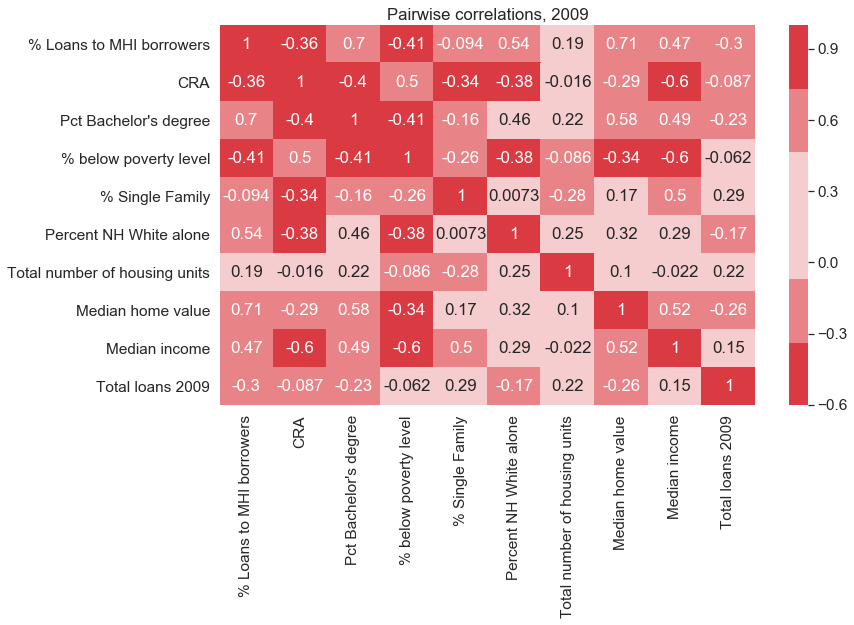

In [103]:
# color = sns.cubehelix_palette(8, start=.5, rot=-.75)
# color = sns.diverging_palette(11, 11)
# sns.set(font_scale=1.4)
# plt.subplots(figsize=(12,7))
# sns.heatmap(x_vars_09_corr, annot=True, cmap=color);
# plt.title("Pairwise correlations, 2009")
# plt.savefig('/Users/ameliabaum/Desktop/Amelia/CRA_Thesis/communityreinvestmentact/results/screenshots/x_vars_09_corr.png', bbox_inches="tight")




In [16]:
x_vars_1314_corr = x_vars_1314[['% Loans to MHI borrowers', 'CRA',
       'Pct Bachelor\'s degree',
       '% below poverty level', '% Single Family', 'Percent NH White alone',
       'Total number of housing units', 'Median home value', 'Median income',
       'Total loans 2013-2014']].corr()
x_vars_1314_corr.head()


,% Loans to MHI borrowers,CRA,Pct Bachelor's degree,% below poverty level,% Single Family,Percent NH White alone,Total number of housing units,Median home value,Median income,Total loans 2013-2014
% Loans to MHI borrowers,1.000000,-0.317489,0.647519,-0.374651,-0.106778,0.418109,0.113015,0.701357,0.450636,0.017019
CRA,-0.317489,1.000000,-0.398729,0.502685,-0.339555,-0.383480,-0.015843,-0.290231,-0.602898,-0.201899
Pct Bachelor's degree,0.647519,-0.398729,1.000000,-0.413253,-0.156600,0.461804,0.221544,0.578136,0.491073,-0.011249
% below poverty level,-0.374651,0.502685,-0.413253,1.000000,-0.264359,-0.378048,-0.085869,-0.336139,-0.603070,-0.205127
% Single Family,-0.106778,-0.339555,-0.156600,-0.264359,1.000000,0.007342,-0.282186,0.171847,0.495243,0.154461


Text(0.5, 1.0, 'Pairwise correlations, 2013-2014')

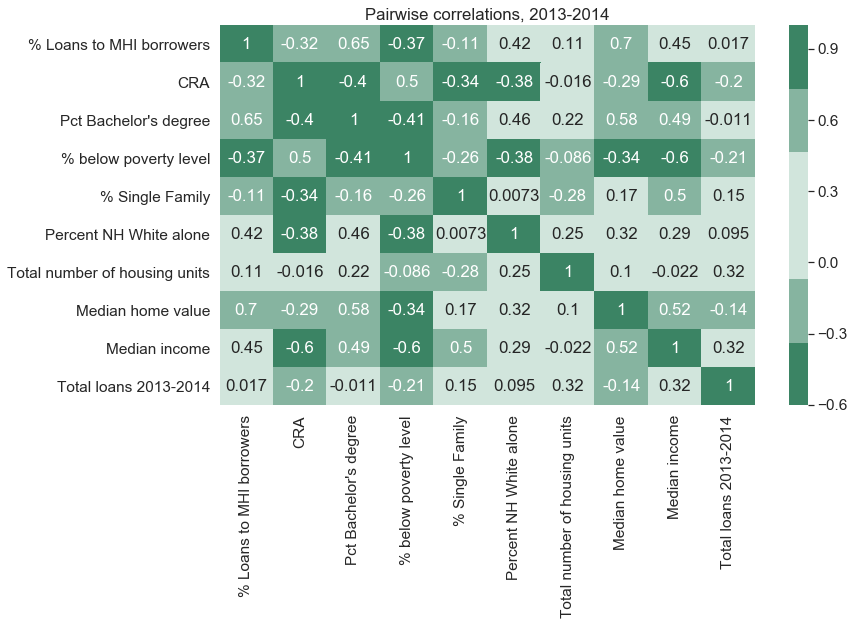

In [19]:
# color = sns.cubehelix_palette(8, start=.5, rot=-.75)
# color = sns.diverging_palette(150, 150)
# sns.set(font_scale=1.4)
# plt.subplots(figsize=(12,7))
# sns.heatmap(x_vars_1314_corr, annot=True, cmap=color);
# plt.title("Pairwise correlations, 2013-2014")
# plt.savefig('/Users/ameliabaum/Desktop/Amelia/CRA_Thesis/communityreinvestmentact/results/screenshots/x_vars_1314_corr.png', bbox_inches="tight")




In [20]:

x_vars_151617_corr = x_vars_151617[['% Loans to MHI borrowers', 'CRA',
       'Pct Bachelor\'s degree',
       '% below poverty level', '% Single Family', 'Percent NH White alone',
       'Total number of housing units', 'Median home value', 'Median income',
       'Total loans 2015-2017']].corr()
x_vars_151617_corr.head()


,% Loans to MHI borrowers,CRA,Pct Bachelor's degree,% below poverty level,% Single Family,Percent NH White alone,Total number of housing units,Median home value,Median income,Total loans 2015-2017
% Loans to MHI borrowers,1.000000,-0.294829,0.566739,-0.342806,-0.044779,0.318508,0.032717,0.641582,0.406627,-0.222136
CRA,-0.294829,1.000000,-0.398729,0.502685,-0.339555,-0.383480,-0.015843,-0.290231,-0.602898,-0.156266
Pct Bachelor's degree,0.566739,-0.398729,1.000000,-0.413253,-0.156600,0.461804,0.221544,0.578136,0.491073,-0.092425
% below poverty level,-0.342806,0.502685,-0.413253,1.000000,-0.264359,-0.378048,-0.085869,-0.336139,-0.603070,-0.136091
% Single Family,-0.044779,-0.339555,-0.156600,-0.264359,1.000000,0.007342,-0.282186,0.171847,0.495243,0.154926


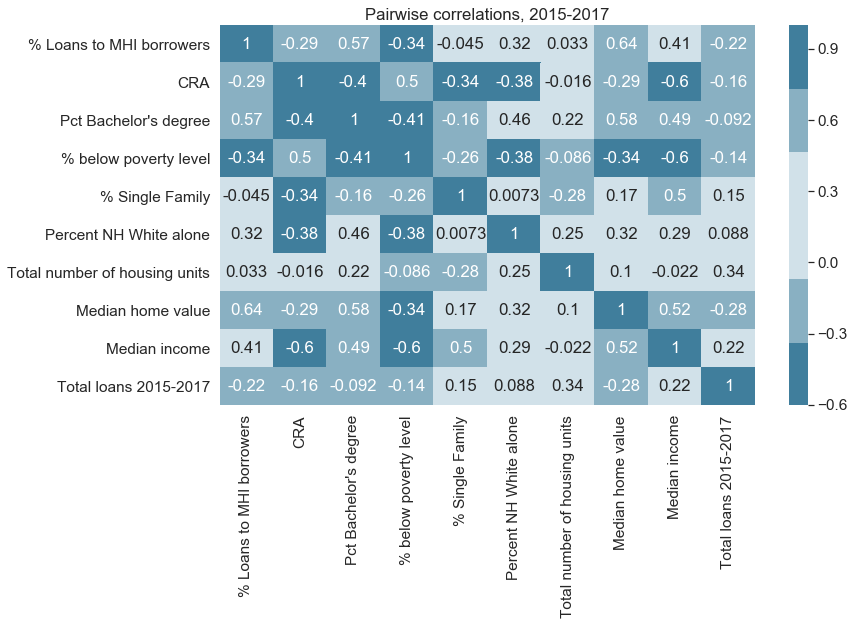

In [22]:
# color = sns.diverging_palette(230, 230)
# sns.set(font_scale=1.4)
# plt.subplots(figsize=(12,7))
# sns.heatmap(x_vars_151617_corr, annot=True, cmap=color);
# plt.title("Pairwise correlations, 2015-2017")
# plt.savefig('/Users/ameliabaum/Desktop/Amelia/CRA_Thesis/communityreinvestmentact/results/screenshots/x_vars_151617_corr.png', bbox_inches="tight")


